In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Cleaning**

In [9]:
df = pd.read_csv('synthetic_data.csv')

# Check for missing values
df.isnull().sum()

x         0
y         0
z         0
status    0
dtype: int64

In [10]:
# Remove duplicates
df.drop_duplicates()

,x,y,z,status
0,-0.123084,-0.909835,-0.399468,idle
1,-0.120303,-0.903106,-0.381034,idle
2,-0.123200,-0.893145,-0.454663,idle
3,-0.136790,-0.916880,-0.454484,idle
4,-0.129392,-0.911907,-0.371385,idle
...,...,...,...,...
299995,0.829013,0.188025,0.411385,used
299996,0.836796,0.229350,0.286411,used
299997,0.761621,0.206068,0.390765,used
299998,0.846855,0.359300,0.419307,used


In [11]:
idle_data = df[df['status'] == 'idle']
false_motion_data = df[df['status'] == 'false_motion']
used_data = df[df['status'] == 'used']
 

**Remove Outliers Using Z-Score**

In [12]:
from scipy.stats import zscore

def remove_outliers_by_zscore(data, columns, threshold=3):
    z_scores = zscore(data[columns])
    return data[(z_scores < threshold).all(axis=1)]

idle_data_cleaned = remove_outliers_by_zscore(idle_data, ['x', 'y', 'z'])
false_motion_data_cleaned = remove_outliers_by_zscore(false_motion_data, ['x', 'y', 'z'])
used_data_cleaned = remove_outliers_by_zscore(used_data, ['x', 'y', 'z'])


In [13]:
df = pd.concat([
    idle_data_cleaned,
    false_motion_data_cleaned,
    used_data_cleaned
])

df.reset_index(drop=True, inplace=True)


**Normalization of Data**

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

In [15]:
df.head()

,x,y,z,status
0,-0.684239,-0.711587,-0.662894,idle
1,-0.678343,-0.699115,-0.616431,idle
2,-0.684485,-0.680654,-0.802017,idle
3,-0.713295,-0.724643,-0.801567,idle
4,-0.697612,-0.715426,-0.592110,idle


**Feature Engineering**

In [16]:
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [17]:
window_size = 10

# Calculate rolling mean, standard deviation, max, and min
df['rolling_mean'] = df['magnitude'].rolling(window=window_size).mean()
df['rolling_std'] = df['magnitude'].rolling(window=window_size).std()
df['rolling_max'] = df['magnitude'].rolling(window=window_size).max()
df['rolling_min'] = df['magnitude'].rolling(window=window_size).min()


In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['status_encoded'] = encoder.fit_transform(df['status'])


**Train Test Split**

In [19]:
from sklearn.model_selection import train_test_split

X = df[['magnitude', 'rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min']]
y = df['status_encoded']

# Handle NaN values generated by rolling operations
X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Model**

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [21]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

           0       0.97      0.94      0.95     19879
           1       0.94      0.97      0.95     19864
           2       1.00      1.00      1.00     20015

    accuracy                           0.97     59758
   macro avg       0.97      0.97      0.97     59758
weighted avg       0.97      0.97      0.97     59758

Accuracy: 0.97


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f}")


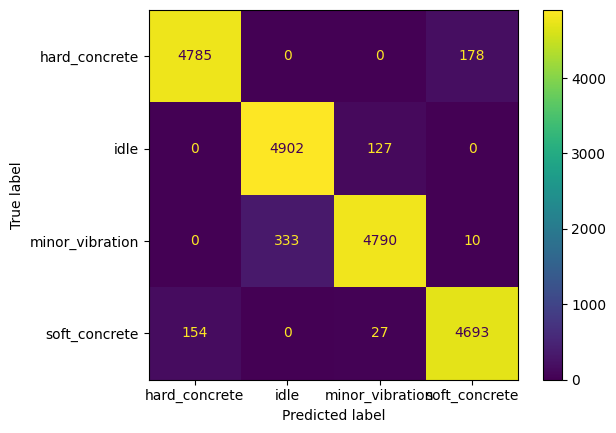

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()


In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=encoder.classes_))


                 precision    recall  f1-score   support

  hard_concrete       0.97      0.96      0.97      4963
           idle       0.94      0.97      0.96      5029
minor_vibration       0.97      0.93      0.95      5133
  soft_concrete       0.96      0.96      0.96      4874

       accuracy                           0.96     19999
      macro avg       0.96      0.96      0.96     19999
   weighted avg       0.96      0.96      0.96     19999



In [ ]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_acc = baseline.score(X_test, y_test)
print(f"Baseline Accuracy: {baseline_acc:.2f}")


Baseline Accuracy: 0.24


**Save Model**

In [22]:
import joblib

joblib.dump(clf, "classify_status_model.pkl")

['classify_status_model.pkl']

In [23]:
df.head()

,x,y,z,status,magnitude,rolling_mean,rolling_std,rolling_max,rolling_min,status_encoded
0,-0.684239,-0.711587,-0.662894,idle,1.189103,NaN,NaN,NaN,NaN,1
1,-0.678343,-0.699115,-0.616431,idle,1.152778,NaN,NaN,NaN,NaN,1
2,-0.684485,-0.680654,-0.802017,idle,1.255006,NaN,NaN,NaN,NaN,1
3,-0.713295,-0.724643,-0.801567,idle,1.294762,NaN,NaN,NaN,NaN,1
4,-0.697612,-0.715426,-0.592110,idle,1.161504,NaN,NaN,NaN,NaN,1


In [24]:
df.to_csv("classify_status.csv", index=False)

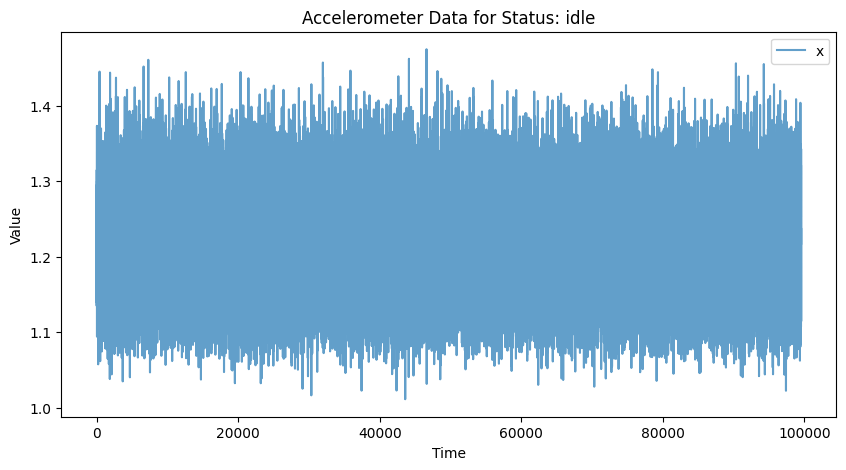

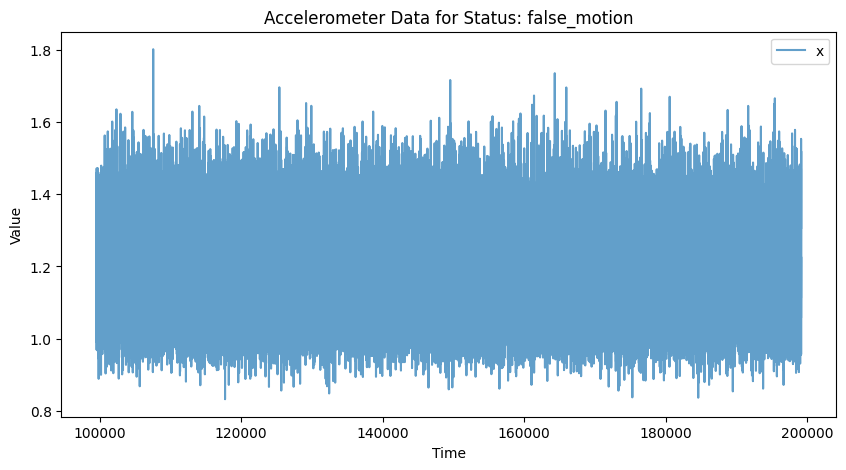

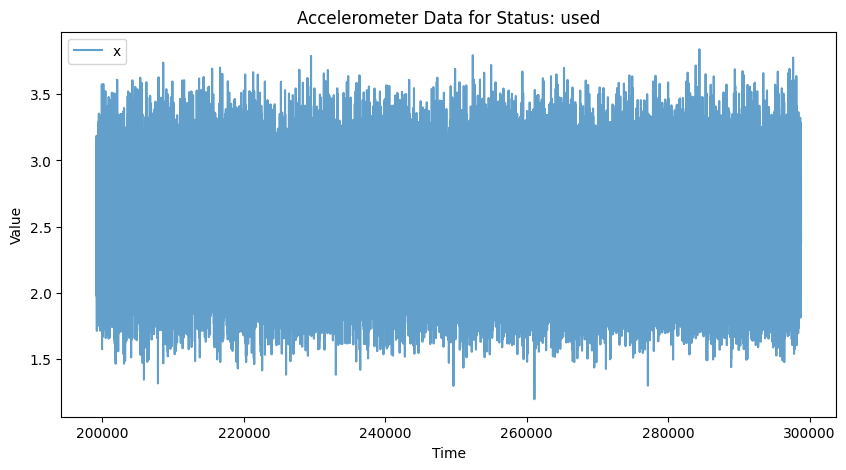

In [26]:
df['time'] = range(len(df))
statuses = df['status'].unique()

for status in statuses:
    subset = df[df['status'] == status]
    plt.figure(figsize=(10, 5))
    plt.plot(subset['time'], subset['magnitude'], label='x', alpha=0.7)
    plt.title(f'Accelerometer Data for Status: {status}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

**Calculate mean and standard deviation of magnitude for each scenarios**

In [27]:
stats = df.groupby('status')['magnitude'].agg(['mean', 'std']).reset_index()
stats.columns = ['status', 'mean_magnitude', 'std_magnitude']

stats

,status,mean_magnitude,std_magnitude
0,false_motion,1.191041,0.108628
1,idle,1.215969,0.056810
2,used,2.444441,0.334124
